In [1]:
import os
import pathlib
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import random

In [3]:
path = 'DatasetAbdalgwad'
dir_names = [ 'Acne and Rosacea Photos', 'Eczema Photos', 'Melanoma Skin Cancer Nevi and Moles', 'Normal', 'vitiligo' ]

for file in dir_names:
    dir = os.listdir(f"{path}/{file}")
    print(f"Data for {file} is {len(dir)}")

Data for Acne and Rosacea Photos is 312
Data for Eczema Photos is 309
Data for Melanoma Skin Cancer Nevi and Moles is 116
Data for Normal is 199
Data for vitiligo is 153


In [4]:
output_dir = pathlib.Path('DatasetAbdalgwad')
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

training_main = pathlib.Path('DatasetAbdalgwad')

1072


In [5]:
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(150, 150),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(150, 150),
    batch_size=batch_size
)

Found 1083 files belonging to 5 classes.
Using 867 files for training.
Found 1083 files belonging to 5 classes.
Using 216 files for validation.


In [6]:
IMG_SIZE = (150, 150)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling='max')
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.070), activity_regularizer=regularizers.l1(0.008),
          bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [7]:
# Load the data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory='DatasetAbdalgwad',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory='DatasetAbdalgwad',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,  # Train for 25 epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add Early Stopping callback
)

Found 1083 images belonging to 5 classes.
Found 1083 images belonging to 5 classes.
Epoch 1/25
17/17 [==============================] - 49s 3s/step - loss: 2.2584 - accuracy: 0.2872 - val_loss: 1.4011 - val_accuracy: 0.5023
Epoch 2/25
17/17 [==============================] - 34s 2s/step - loss: 1.2368 - accuracy: 0.5115 - val_loss: 1.0071 - val_accuracy: 0.6288
Epoch 3/25
17/17 [==============================] - 31s 2s/step - loss: 0.9155 - accuracy: 0.6436 - val_loss: 0.6792 - val_accuracy: 0.7516
Epoch 4/25
17/17 [==============================] - 32s 2s/step - loss: 0.6806 - accuracy: 0.7470 - val_loss: 0.5176 - val_accuracy: 0.8135
Epoch 5/25
17/17 [==============================] - 29s 2s/step - loss: 0.5301 - accuracy: 0.8006 - val_loss: 0.5326 - val_accuracy: 0.8107
Epoch 6/25
17/17 [==============================] - 30s 2s/step - loss: 0.4188 - accuracy: 0.8486 - val_loss: 0.3376 - val_accuracy: 0.8809
Epoch 7/25
17/17 [==============================] - 28s 2s/step - loss: 0.33

In [8]:
# Evaluate the model
model.evaluate(validation_generator)

17/17 [==============================] - 9s 467ms/step - loss: 0.0418 - accuracy: 0.9982


[0.04177626967430115, 0.9981532692909241]

Found 1083 images belonging to 5 classes.
17/17 [==============================] - 9s 516ms/step
Classification Report
                                     precision    recall  f1-score   support

            Acne and Rosacea Photos       1.00      1.00      1.00       312
                      Eczema Photos       1.00      1.00      1.00       309
Melanoma Skin Cancer Nevi and Moles       0.99      0.99      0.99       116
                             Normal       1.00      1.00      1.00       193
                           vitiligo       1.00      1.00      1.00       153

                           accuracy                           1.00      1083
                          macro avg       1.00      1.00      1.00      1083
                       weighted avg       1.00      1.00      1.00      1083

Confusion Matrix
[[312   0   0   0   0]
 [  0 308   1   0   0]
 [  1   0 115   0   0]
 [  0   0   0 193   0]
 [  0   0   0   0 153]]


Text(95.7222222222222, 0.5, 'True Labels')

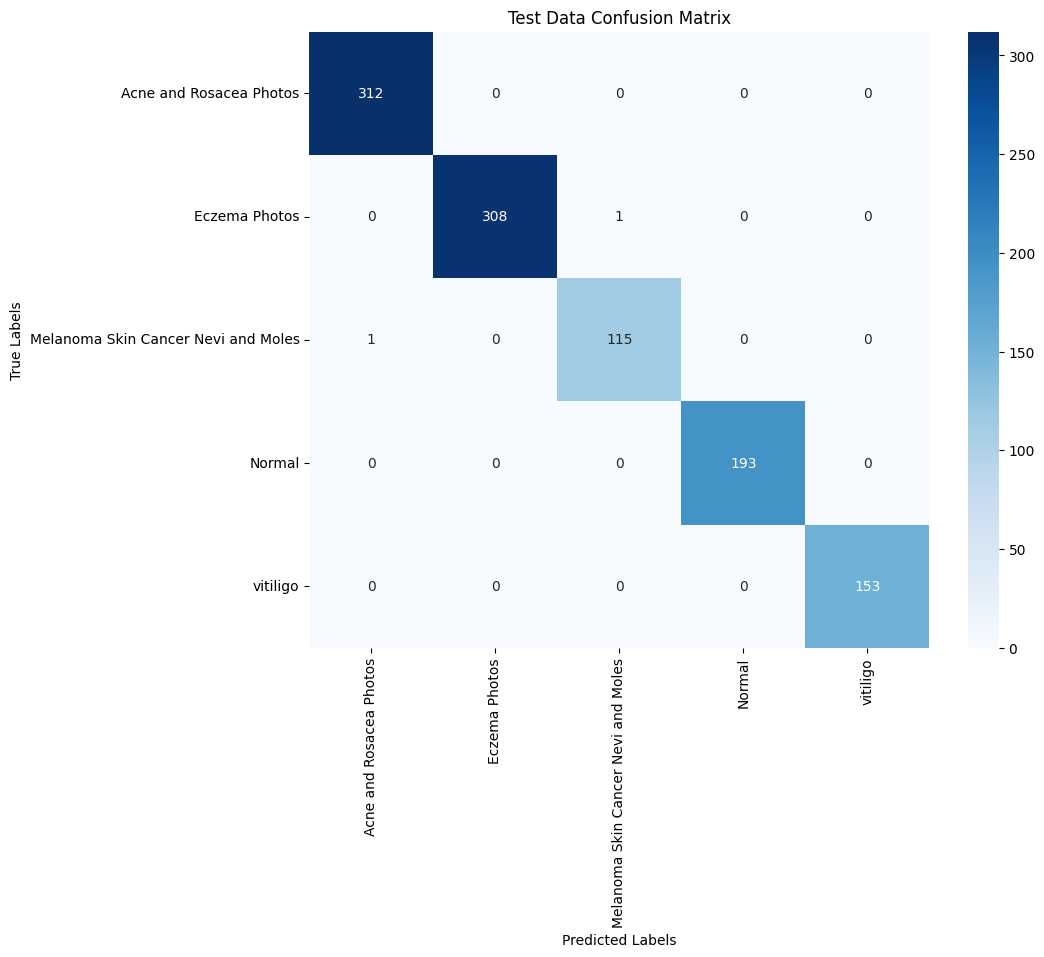

In [9]:
# Data testing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='DatasetAbdalgwad',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predicting the test data
Y_pred_test = model.predict(test_generator, len(test_generator))
y_pred_test = np.argmax(Y_pred_test, axis=1)

# True labels from test generator
y_true_test = test_generator.classes

# Classification report and confusion matrix
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

print('Confusion Matrix')
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print(conf_matrix_test)

# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

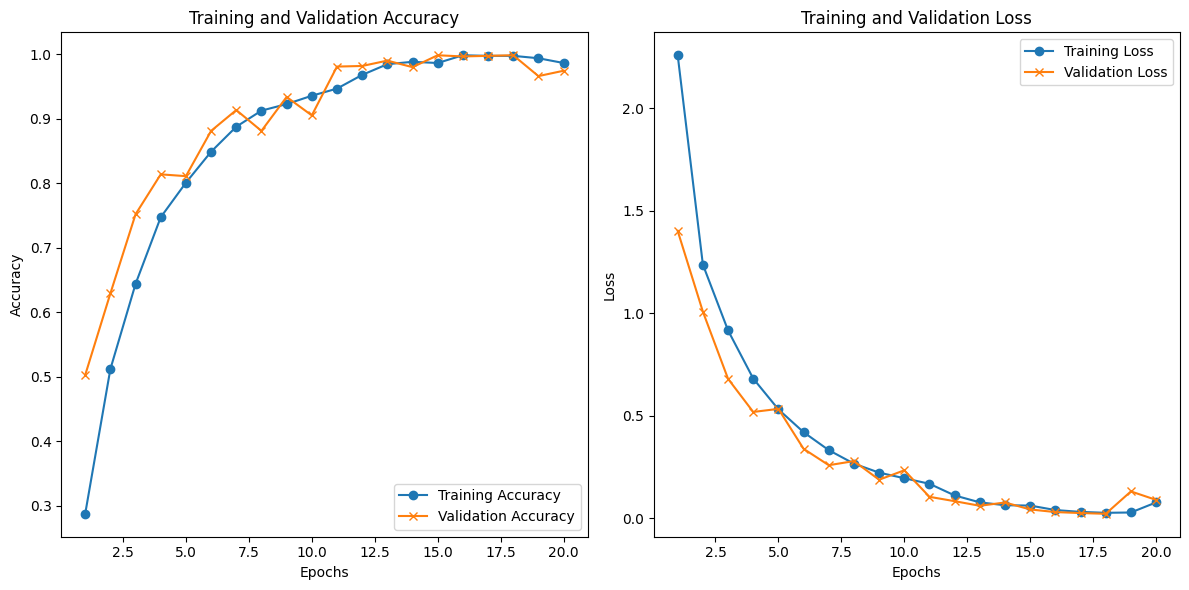

In [10]:
# Plotting accuracy and loss for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()